In [97]:
import numpy as np
rng = np.random.default_rng()

def DIST(A):
    n = len(A)
    D = np.ndarray((n, n))
    T = np.ndarray((n, n))
    B = np.matmul(A,A) / n
    for ind in range(n):           
        np.subtract(B, B[ind], out=T)
        np.fill_diagonal(T, 0)
        D[ind] = np.amax(np.abs(T), axis=1)
    return D.T 


def NBS_(A, D):
    n = len(D)
    tr = int(np.sqrt(np.log(n)*n)) 
    N = np.argsort(D, axis=1).take(list(range(1,tr+1)), axis=1)
    P = np.ndarray((n,n))    
    for i in range(n):
        #print(np.sum(A.take(N[i], axis=1),axis=1),D.take(N[i], axis=1)[i] )
        P[i] = np.sum(A.take(N[i], axis=1), axis=1) / tr
    np.fill_diagonal(P, 1)
    P = (P + P.T)/2
    return P, N


def NBS(A, D):
    return  NBS_(A, D)[0]


def DE2(graf1, graf2):
    D_A, ind_a = graf1
    D_B, ind_b = graf2
    a_set, b_set = set(ind_a), set(ind_b)
    n = len(a_set | b_set)
    D = np.ndarray((n, n))

    
    blok_1_ind = sorted(a_set - b_set)
    ind = list(map(ind_a.get, blok_1_ind))
    tmp_a = D_A.take(ind, 0)
    blok_1 = tmp_a.take(ind, 1)
    #print('blok_1\n',blok_1)
    
    blok_9_ind = sorted(b_set - a_set)
    ind = list(map(ind_b.get, blok_9_ind))
    tmp_b = D_B.take(ind, 0)
    blok_9 = tmp_b.take(ind, 1)
    #print('blok_9\n',blok_9)
    
    blok_5_ind = sorted(b_set & a_set)
    ind_1, ind_2 = list(map(ind_a.get, blok_5_ind)),  list(map(ind_b.get, blok_5_ind))
    t1 = D_A.take(ind_1, 1).take(ind_1, 0) 
    t2 = D_B.take(ind_2, 1).take(ind_2, 0)
    blok_5 = (t1 + t2)/2
    #print('blok_5\n',blok_5)
     
    i_n, j_n = len(b_set - a_set), len(a_set - b_set), 
    blok_2_4 = tmp_a.take(ind_1, 1)
    blok_6_8 = tmp_b.take(ind_2, 1)
    #print('blok_2_4\n',blok_2_4)
    #print('blok_6_8\n',blok_6_8)
 
    blok_3_7 = np.ndarray((i_n, j_n))
    Ta, Ts1, Ts2 = np.ndarray(blok_2_4.shape), np.ndarray(blok_2_4.shape), np.ndarray(blok_2_4.shape)
    for i in range(i_n):
        np.add(blok_2_4, blok_6_8[i], out=Ta)
        np.subtract(blok_2_4, blok_6_8[i], out=Ts1)
        np.fabs(Ts1, out=Ts2)
        t1, t2 = np.amin(Ta, axis=1), np.amax(Ts2, axis=1)    
        t3 = np.where(t1 + t2 == 0, 0, 1/(t1+t2))        
        blok_3_7[i] = 2*(t1*t2)/t3
    #print('blok_3_7\n',blok_3_7)
            
    D = np.block([[blok_1, blok_2_4, blok_3_7.T], [blok_2_4.T, blok_5, blok_6_8.T], [blok_3_7, blok_6_8, blok_9]])
           
    d_ind = dict(zip(blok_1_ind + blok_5_ind + blok_9_ind, range(n)))
           
    return D, d_ind   


def DE(D_gr, trav):
    D_graf = D_gr[trav[0]]
    for t in trav[1:]: 
        D_graf = DE2(D_graf, D_gr[t])         
    D, d = D_graf
    ind = [d[x] for x in sorted(d)]
    D = D.take(ind, axis=1).take(ind, axis=0)
    return D


def NBSE0(A, graph_dist, I, J):
    n = len(graph_dist)   
    super_graph = get_super_graph(graph_dist) 
    
    D = np.zeros(A.shape)
    trav=[x for x in range(n)]
    for i in range(I):        
        sp_tree = super_graph.spanning_tree()
        for j in range(J):
            rng.shuffle(trav)
            D += DE(graph_dist, trav)  
    D = D / (I*J)
    return NBS_(A, D)


def CORR(A, P, N):
    shape = P.shape
    tr = N.shape[1]
    P_cor = np.ndarray(shape)
    A_cor = np.where(A == 0 , P, 1) 
    for i in range(shape[0]):
        P_cor[i] = np.sum(A_cor.take(N[i], axis=1), axis=1) / tr
    np.fill_diagonal(P_cor, 1)
    P_cor = (P_cor + P_cor.T)/2
    return (A, P_cor, N)


def NBSE(graphs, delta, I=2, J=1):  
    
    t = graphs[0]
    for g in graphs[1:]:
        t |= g
    name = [int(x) for x in t.vs["name"]]
    d = dict(zip(name,range(len(name))))
    ind = [d[x] for x in sorted(name)]
    A = np.array(t.get_adjacency().data)
    A = A.take(ind, axis=1).take(ind, axis=0)
    d = d = dict(zip(sorted(ind),range(len(ind))))
    
    Dists = list()
    for g in graphs:
        t = g.vs["name"]
        ind = [int(x) for x in t]
        t = dict(zip(ind,range(len(ind))))
        D = DIST(np.array(g.get_adjacency().data))
        Dists.append((D,t))
    

    old_par = (A,) + NBSE0(A, Dists, I, J)
    n = old_par[1].shape[0]   
    diff_sum = float("inf")
    while delta != None and diff_sum > delta:
        par = CORR(*old_par)
        diff = par[1] - old_par[1]
        diff_sum = np.sqrt(np.sum(np.square(diff)))/n
        old_par = par
            
    return old_par[1],d


def get_super_graph(Graph_dist):
    n = len(Graph_dist)
    super_graph = Graph(n)
    super_graph.es["weight"] = 1
    for i in range(n):
        for j in range(i,n):
            super_graph[i, j] = len(set(Graph_dist[i][1]) & set(Graph_dist[j][1]) )
    return super_graph

In [83]:
from igraph import * 
import matplotlib.pyplot as plt
import sklearn.cluster as cls

def DIST_P(P):
    n = P.shape[0]
    D, T = np.ndarray((n, n)), np.ndarray((n, n))
    for ind in range(n):           
        np.subtract(P, P[ind], out=T)
        D[ind] = np.sum(np.abs(T), axis=1)
    return D.T/np.max(D)

def sort_by_sum(P): 
    S = np.sum(P, axis=1)
    ind = np.argsort(S)
    return P.take(ind, axis=0).take(ind, axis=1)


def cluster_by_P(P): 
    n = len(P)
    D = DIST_P(P)
    mdl = cls.SpectralClustering(n_clusters = 6 ,affinity='precomputed') #AffinityPropagation
    cor = np.where(D == 0, 1, D)
    c = mdl.fit_predict(1/cor)
    l = np.argsort(c)
    #print(c)
    return P.take(l, axis=1).take(l, axis=0)

def P_d(P1, P2):
    return np.sqrt(np.sum((P1-P2)**2)/P1.shape[0])


In [106]:
n = 60
nob = 4

r = sorted(rng.choice(range(n), nob - 1))
r.append(n)
r.insert(0,0)
#r = [0,int(1/3*n),int(2/3*n),n]


blok_sizes = [r[x+1] - r[x] for x in range(nob)]
r = rng.random((nob,nob))
blok_prob = (r+r.T)/3
#blok_prob = [[0.5,0.2,0.1],[0.2,0.7,0.4],[0.3,0.4,0.9]]

G = Graph.SBM(n, list(blok_prob), blok_sizes)
A = np.array(G.get_adjacency().data)

ind = np.arange(n)
rng.shuffle(ind)
G.vs["name"] = [str(x) for x in ind]

d = dict(zip(ind,range(len(ind))))
ind = [d[x] for x in sorted(ind)]

A = A.take(ind, axis=1).take(ind, axis=0)

        

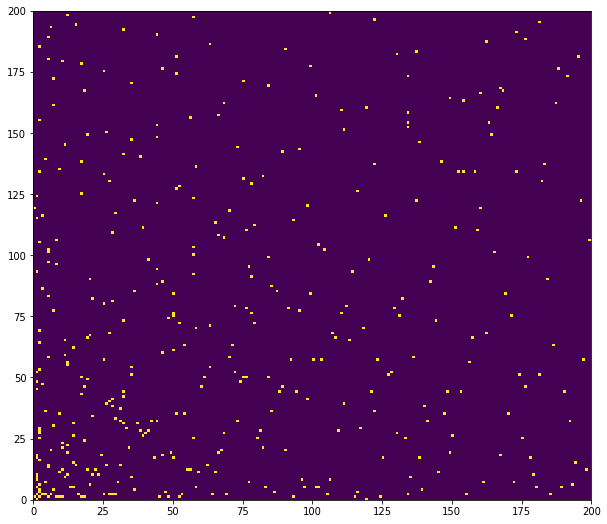

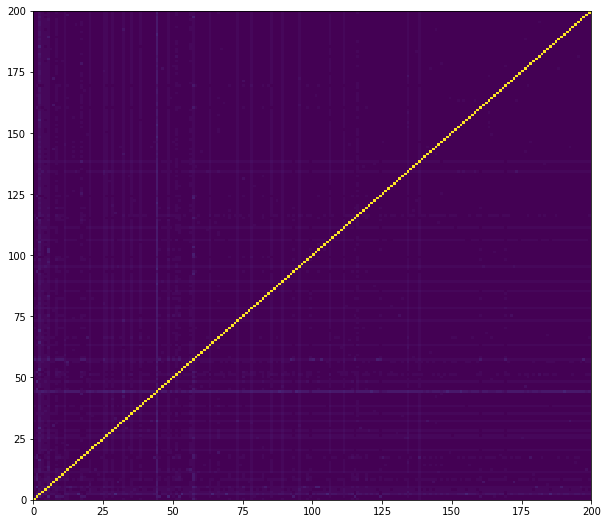

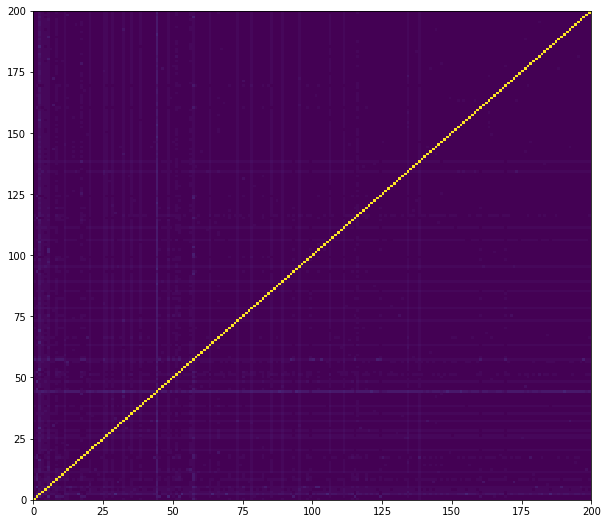

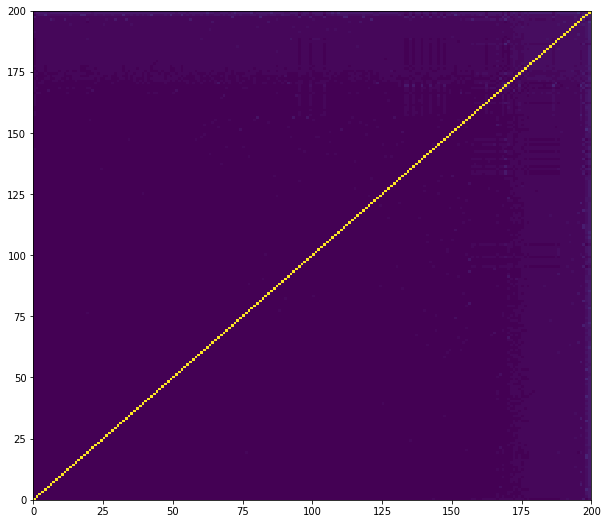

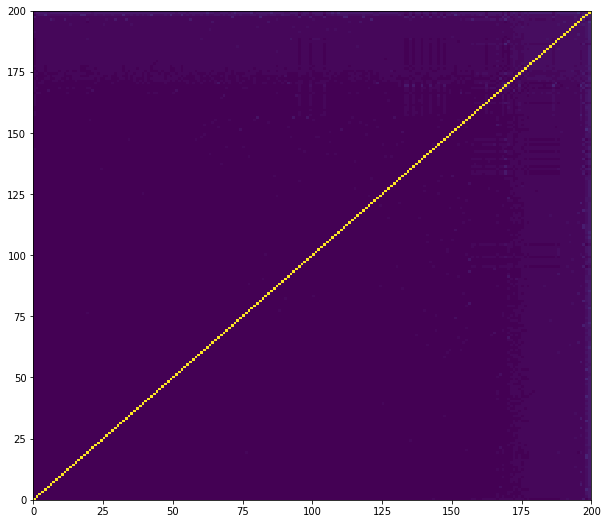

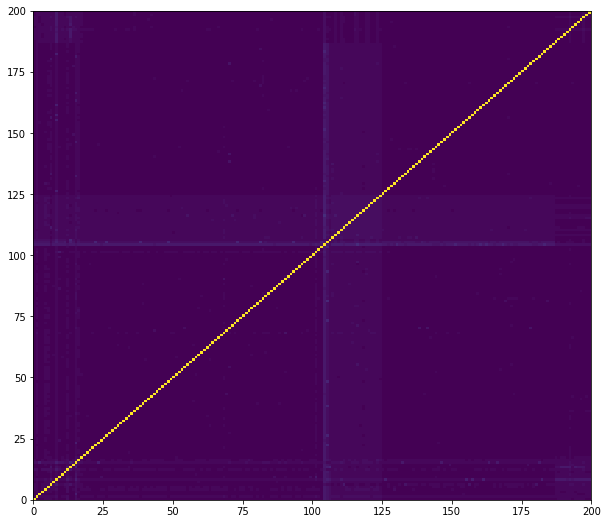

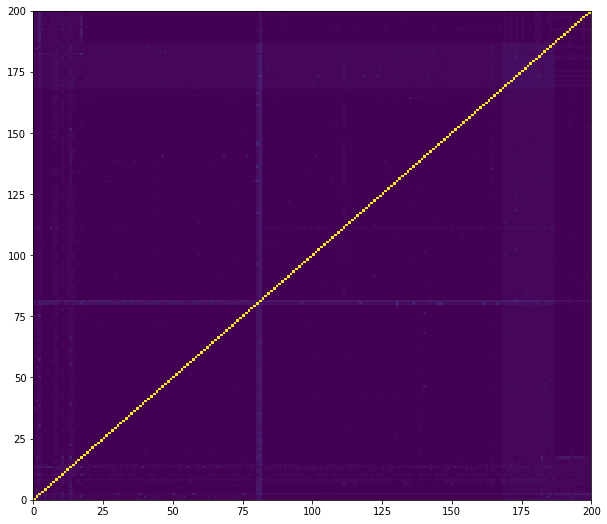

In [121]:
nog = 4
k = int(n/nog*3)
ind = G.vs.indices
graphs = list()
for i in range(nog):    
    rng.shuffle(ind)
    t = G.subgraph(ind[:k])
    graphs.append(t)
    
R = NBS(A, DIST(A))
P = NBSE(graphs, None,3,3)[0]

fig, ax = plt.subplots(figsize=(10,9))
ax.pcolormesh( A)

fig, ax = plt.subplots(figsize=(10,9))
ax.pcolormesh(R)
fig, ax = plt.subplots(figsize=(10,9))
ax.pcolormesh(P)

fig, ax = plt.subplots(figsize=(10,9))
ax.pcolormesh(sort_by_sum(R))
fig, ax = plt.subplots(figsize=(10,9))
ax.pcolormesh(sort_by_sum(P))


fig, ax = plt.subplots(figsize=(10,9))
ax.pcolormesh(cluster_by_P(R))
fig, ax = plt.subplots(figsize=(10,9))
ax.pcolormesh(cluster_by_P(P))

p = plot(G, vertex_size=5)
p

[0.19017724523477525,
 0.19024433934770874,
 0.20337915008340696,
 0.1950517547646995,
 0.20791304322376797,
 0.18721348319536413,
 0.20742608447748198,
 0.1835793320977865,
 0.1820941353555778,
 0.18832057358784968]

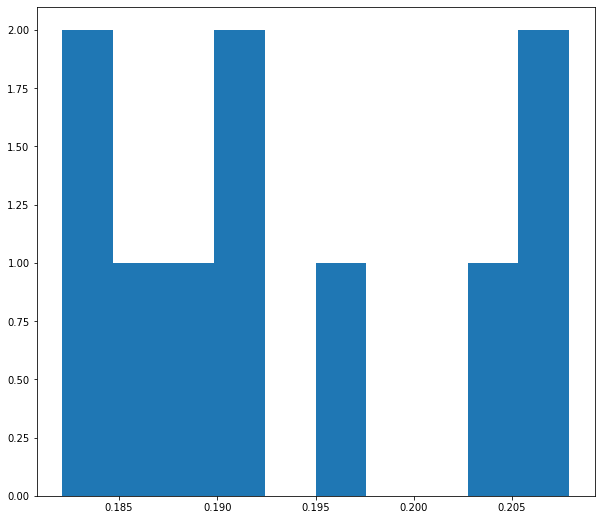

In [120]:
s = 200
k = 100
nog = 3
m = int(s/nog*1.3)
res = []
for i in range(k):
    G = Graph.Barabasi(s)
    G.vs["name"] = [str(x) for x in range(s)]
    
    A = np.array(G.get_adjacency().data)    
    P1 = NBS(A, DIST(A))
    
    ind = G.vs.indices
    graphs = list()
    for i in range(nog):    
        rng.shuffle(ind)
        t = G.subgraph(ind[:m])
        graphs.append(t)

    P2, d  = NBSE(graphs, None, 2, 4)

    l = list(d)
    P1 = P1.take(l, axis=1).take(l, axis=0)
    res.append(P_d(P1, P2))

fig, ax = plt.subplots(figsize=(10,9))
ax.hist(res)

In [6]:
with open("econ-beaflw.mtx") as f:
    n = 0
    for x in f:
        if x[0] == '%':
            continue
        line = x.split()
        lm = max(int(line[0]),int(line[1]))
        if lm > n:
            n = lm
            
A = np.ndarray((n,n))
np.fill_diagonal(A, 1)
with open("econ-beaflw.mtx") as f:
    for s in f:
        if s[0] == '%':
            continue
        line = s.split()
        x, y = int(line[0]) - 1 , int(line[1]) - 1
        if abs(float(line[2])) != 0:
            A[x,y] = 1
                      

In [7]:
with open("bn-mouse_retina_1.edges") as f:
    n = 0
    for x in f:
        line = x.split()
        lm = max(int(line[0]),int(line[1]))
        if lm > n:
            n = lm
            
n += 1
A = np.ndarray((n,n))
#np.fill_diagonal(A, 1)
with open("bn-mouse_retina_1.edges") as f:
    for s in f:
        line = s.split()
        x, y = int(line[0]), int(line[1])
        A[x,y] = A[y,x] = 1
            